In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')

def convert_volume(value):
    if pd.isna(value) or value == '-':
        return 0.0
    value = str(value).upper()
    try:
        if 'K' in value:
            return float(value.replace('K', '').replace(',', '')) * 1000
        if 'M' in value:
            return float(value.replace('M', '').replace(',', '')) * 1000000
        return float(value.replace(',', ''))
    except:
        return 0.0
    
def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    
    df_gold['Vol.'] = df_gold['Vol.'].apply(convert_volume)
    
    df_gold = df_gold.sort_values('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv')
    df_fed['Date'] = pd.to_datetime(df_fed['observation_date'])
    df_fed = df_fed.set_index('Date')[['FEDFUNDS']]

    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv')
    df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])
    df_cpi = df_cpi.set_index('Date')[['CORESTICKM159SFRBATL']]
    
    return df_gold, df_market, df_fed, df_cpi

df_gold, df_market, df_fed, df_cpi = load_and_clean_data()

In [22]:
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
df_fed_daily = df_fed.reindex(full_idx, method='ffill')
df_cpi_daily = df_cpi.reindex(full_idx, method='ffill')

df = df_gold.join([df_market, df_fed_daily, df_cpi_daily], how='inner')
df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']

# Tính Log Return cho các biến
assets = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD', 'Vol.']
for a in assets:
    df[f'{a}_LogRet'] = np.log(df[a] / df[a].shift(1))

df['Target'] = df['Price'].shift(-1)           # Giá tuyệt đối ngày mai (để so sánh)
df['Target_LogRet'] = df['Price_LogRet'].shift(-1) # Biến động ngày mai (để model học)

df = df.dropna()

feature_cols = [
    'Price_LogRet', 
    'S&P500_LogRet', 
    'SLV_LogRet', 
    'USO_LogRet', 
    'EUR/USD_LogRet', 
    'Vol.',
    'Real_Rate'
]

In [23]:
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[feature_cols]
y_train = train['Target_LogRet']

model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)
walk_forward_price_preds = []
actual_prices_tomorrow = []

print(f"Starting Walk-Forward Prediction for {len(test)} days...")

for i in range(len(test)):
    X_today = test[feature_cols].iloc[[i]]
    pred_log_ret = model.predict(X_today)[0]

    price_today = test['Price'].iloc[i]
    
    price_pred_tomorrow = price_today * np.exp(pred_log_ret)
    walk_forward_price_preds.append(price_pred_tomorrow)
    
    actual_prices_tomorrow.append(test['Target'].iloc[i])


Starting Walk-Forward Prediction for 252 days...



[XGBoost Walk-Forward] Results:
RMSE: 18.12
MAPE: 0.77%
Directional Accuracy: 52.38%


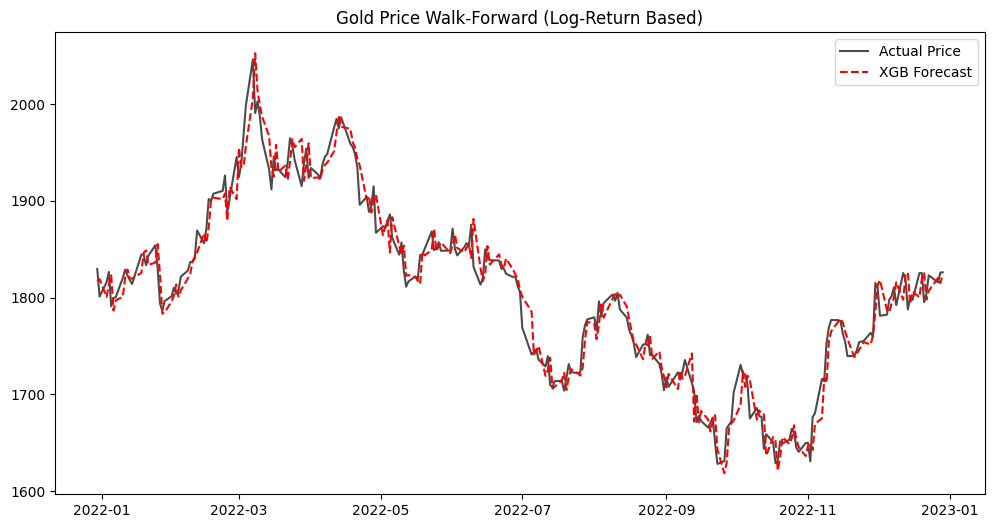

In [24]:
rmse = np.sqrt(mean_squared_error(actual_prices_tomorrow, walk_forward_price_preds))
mape = mean_absolute_percentage_error(actual_prices_tomorrow, walk_forward_price_preds) * 100

# Directional Accuracy
actual_diff = np.sign(np.array(actual_prices_tomorrow) - test['Price'].values)
pred_diff = np.sign(np.array(walk_forward_price_preds) - test['Price'].values)
acc = np.mean(actual_diff == pred_diff) * 100

print(f"\n[XGBoost Walk-Forward] Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {acc:.2f}%")

# 6. PLOT
plt.figure(figsize=(12, 6))
plt.plot(test.index, actual_prices_tomorrow, label='Actual Price', color='black', alpha=0.7)
plt.plot(test.index, walk_forward_price_preds, label='XGB Forecast', color='red', linestyle='--')
plt.title("Gold Price Walk-Forward (Log-Return Based)")
plt.legend()
plt.show()